In [6]:
import numpy as np # быстрые математические вычисления, работа с массивами
import matplotlib.pyplot as plt # рисует графики, поля, траектории
from scipy.integrate import solve_ivp # находит численное решение дифф уравнений

In [7]:
def f1(gamma, sigma): # это параметр омега в линейном осцилляторе
    def rhs(t,X): # правая часть ДУ
        x, y = X # Х - это вектор состояния системы
        return [y,-2*gamma*y-sigma*x] # возведение в степекнь ** умножение *
    return rhs

In [8]:
rhs = f1(1.0,1.0) # создаем систему уравнений с gamma =1.0
rhs(10.0, [1.0,2.0])

[2.0, -5.0]

In [9]:
# функция для вычисления векторного поля 
#передаем функцию вычисления производных лимит список границ для осей x и y 
#N - количество точек стеки по каждой оси на которой будет отображаться вектор
def eq_quiver(rhs, limits, N=16):
    xlims, ylims = limits
    
    #Определение сетки
    xs = np.linspace(xlims[0],xlims[1], N) # разбивает равномерно отрезок на N точек
    ys = np.linspace(ylims[0],ylims[1], N)
    
    #Инициализция массивов для компонент вектоорв
    U = np.zeros((N,N))
    V = np.zeros((N,N))
    
    #U[i][j] будет хранить компоненту скорости по оси x
    #V[i][j] - компоненту скорости по оси у для точки с координатами (xs[j], ys[j]?)
    
    for i, y in enumerate (ys):
        for j,x in enumerate (xs):
            vfield = rhs (0.0,[x,y])
            u,v = vfield
            U[i][j] = u
            V[i][j] = v
            # проходим по всемм точкам сетки с координатами х у
            # вызываем функцию rhs(0.0, [x,y]), которая возвращает
            #вектор скорости в этой точке 
            #значение компонент вектора u v сохраняются в массивы U V
    return xs, ys, U, V

In [10]:
def plotonPlane(rhs, limits):
    plt.close()
    xlims, ylims = limits
    plt.xlim(xlims[0],xlims[1])
    plt.ylim(ylims[0], ylims[1])
    xs, ys, U, V = eq_quiver(rhs, limits)
    plt.quiver(xs,ys,U,V,alpha=0.8)

In [11]:
def create_jacobian(gamma, sigma):
    return np.array([[0, 1],
                     [-sigma, -2*gamma]])

In [12]:
def eigenvalues_and_jacobian(gamma, sigma):
    J = create_jacobian(gamma, sigma)

    # eig возвращает: eigenvalues, eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(J)

    return eigenvalues, eigenvectors, J


In [13]:
def stability_type(eigenvalues):
    lambda_1 = complex(eigenvalues[0])
    lambda_2 = complex(eigenvalues[1])
    r1, r2 = lambda_1.real, lambda_2.real
    i1, i2 = lambda_1.imag, lambda_2.imag

    # -------------------------
    # Оба отрицательные
    if r1 < 0 and r2 < 0:
        if abs(i1) > 1e-12 or abs(i2) > 1e-12:
            return "устойчивый фокус", 0
        else:
            if abs(lambda_1 - lambda_2) < 1e-12:
                return "устойчивый вырожденный узел", 1
            else:
                return "устойчивый узел", 2

    # Оба положительные
    if r1 > 0 and r2 > 0:
        if abs(i1) > 1e-12 or abs(i2) > 1e-12:
            return "неустойчивый фокус", 3
        else:
            if abs(lambda_1 - lambda_2) < 1e-12:
                return "неустойчивый вырожденный узел", 4
            else:
                return "неустойчивый узел", 5

    # Разного знака
    if (r1 > 0 and r2 < 0) or (r1 < 0 and r2 > 0):
        return "седло", 6

    # Один ноль, другой отрицательный → нейтральная устойчивость
    if (abs(r1) < 1e-12 and r2 < 0) or (abs(r2) < 1e-12 and r1 < 0):
        return "нейтральный узел", 7

    # Один ноль, другой положительный → неустойчивость
    if (abs(r1) < 1e-12 and r2 > 0) or (abs(r2) < 1e-12 and r1 > 0):
        return "нейтральное седло", 8

    # Чисто мнимые → центр
    if abs(r1) < 1e-12 and abs(r2) < 1e-12:
        if abs(i1 + i2) < 1e-12 and abs(i1) > 1e-12:
            return "центр", 9
        else:
            return "нулевые собственные числа", 10

    # Остальные граничные случаи
    return "сложный/граничный случай", 11


In [14]:
def plot_eigendirections(eigenvalues, eigenvectors, stability, equilibrium=(0, 0), length=10, num_points=20):
    """
    Отрисовка собственных направлений в окрестности точки равновесия.
    """

    x0, y0 = equilibrium

    if stability in (1, 2, 4, 5, 6, 7):
        for i in range(2):
            # Берём собственный вектор и число
            vx, vy = np.real(eigenvectors[:, i])
            eigenvalue = eigenvalues[i]

            # Подготовим массивы координат
            xs = []
            ys = []

            # Заполняем точки "вручную", как в C
            for k in range(num_points):
                t = -length + 2 * length * k / (num_points - 1)
                xs.append(x0 + vx * t)
                ys.append(y0 + vy * t)

            # Цвет по знаку λ
            color = 'b-' if eigenvalue.real < 0 else 'r-'

            # Рисуем линию
            plt.plot(xs, ys, color, linewidth=2, zorder=10)


In [15]:
def plot_equilibrium(stability, equilibrium=(0, 0)):
    x0, y0 = equilibrium

    # Определяем цвет по коду
    if stability in [0, 1, 2]:          # устойчивые
        color = 'b'
    elif stability in [3, 4, 5, 6]:     # неустойчивые
        color = 'r'
    elif stability in [7, 8, 9, 10]:    # нейтральные
        color = 'g'
    else:                          # граничные случаи
        color = 'k'

    plt.scatter(x0, y0, s=100, c=color, zorder=5)


gamma=2, sigma=1
уравнение: x'' + 4x' + 1x = 0
------------------------------------
собственные числа: [-0.26794919 -3.73205081]
собственные вектора: [[ 0.96592583 -0.25881905]
 [-0.25881905  0.96592583]]
тип устойчивости: устойчивый узел


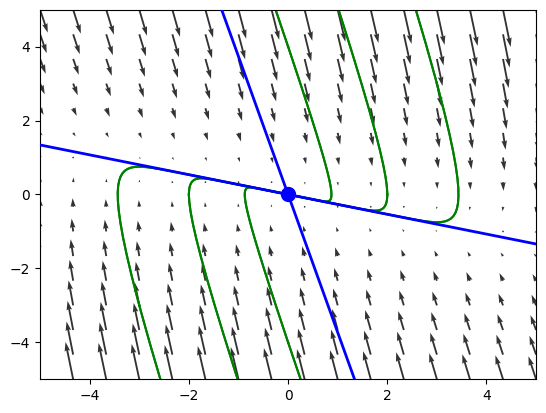

In [18]:
# 2,1 - устойчивый узел, 1,3 - устойчивый фокус, 1,1 - вырожденный устойчивый узел, -2,1 - неустойчивый узел, -1,3 - неустойчивый фокус
# 0,1 - центр, 0,-1 - седло
gamma = 2
sigma = 1

print(f"gamma={gamma}, sigma={sigma}")
print(f"уравнение: x'' + {2*gamma}x' + {sigma}x = 0")
print("------------------------------------")

eigenvalues, eigenvectors, J = eigenvalues_and_jacobian(gamma, sigma)
print(f"собственные числа: {eigenvalues}")
print(f"собственные вектора: {eigenvectors}")
stab, stability = stability_type(eigenvalues)
print("тип устойчивости:", stab)

rhs = f1(gamma, sigma)
plotonPlane(rhs, [(-5.,5.),(-5.,5.)])

plot_eigendirections(eigenvalues, eigenvectors, stability)

plot_equilibrium(stability, equilibrium=(0,0))

# список начальных условий
initial_conditions = [
    [0, 4],
    [0, -4],
    [2, 0],
    [-2, 0],
    [3, 3],
    [-3, -3]
]

# список временных интервалов для интегрирования
t_intervals = [[0, -50], [-50, 0], [50, 0], [0, 50]]

for X0 in initial_conditions:
    for t_span in t_intervals:
        sol = solve_ivp(rhs, t_span, X0, method='RK45', rtol=1e-12)
        plt.plot(sol.y[0], sol.y[1], 'g-')  # траектории зелёным



